In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libcudnn8


In [3]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [4]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-09-20 08:24:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.223.252.218, 2600:1402:6800:290::317f, 2600:1402:6800:2a1::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.223.252.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  34.5MB/s    in 31s     

2022-09-20 08:25:07 (25.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [5]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Görüntü olmayan tüm dosyaları siler (veri kümesinde paketlenmiş iki .db dosyası vardır)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir, verilen yol altındaki tüm dosyaları içeren bir liste döndürür
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [6]:
# Kök dizini tanımlayın
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    
    """
    Creates directories for the train and test sets
    
    Args:
      root_path (string) - the base directory path to create subdirectories from
    
    Returns:
      None
    """  
    ### START CODE HERE
    
    # HINT:
    # Use os.makedirs to create your directories with intermediate subdirectories
    # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
    
    os.mkdir(root_dir)
    os.mkdir(os.path.join(root_dir, 'training'))
    os.mkdir(os.path.join(root_dir, 'validation'))
    os.mkdir(os.path.join(root_dir, 'training/cats'))
    os.mkdir(os.path.join(root_dir, 'training/dogs'))
    os.mkdir(os.path.join(root_dir, 'validation/cats'))
    os.mkdir(os.path.join(root_dir, 'validation/dogs'))

  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [7]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [8]:
# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    
    """
    Splits the data into train and test sets
    
    Args:
      SOURCE_DIR (string): directory path containing the images
      TRAINING_DIR (string): directory path to be used for training
      VALIDATION_DIR (string): directory path to be used for validation
      SPLIT_SIZE (float): proportion of the dataset to be used for training
      
    Returns:
      None
    """
    
    ### START CODE HERE
    files =[]
    for filename in os.listdir(SOURCE_DIR):
        file = SOURCE_DIR + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print("filename is zero length, so ignoring.")
        
        training_length = int(len(files) * SPLIT_SIZE) 
        testing_length = int(len(files) - training_length)
        shuffled_set = random.sample(files, len(files))
        training_set = shuffled_set[0:training_length]
        testing_set = shuffled_set[-testing_length:]
    
    for filename in training_set:
        src_file = SOURCE_DIR + filename
        dest_file = TRAINING_DIR + filename
        copyfile(src_file,dest_file)
        
    for filename in testing_set:
        src_file = SOURCE_DIR + filename
        dest_file = VALIDATION_DIR + filename
        copyfile(src_file,dest_file)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/validation/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/validation/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

    ### END CODE HERE

filename is zero length, so ignoring.
filename is zero length, so ignoring.


In [9]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

filename is zero length, so ignoring.
filename is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [13]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [14]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [33]:
# GRADED FUNCTION: create_model
def create_model():
    
    # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
    # USE AT LEAST 3 CONVOLUTION LAYERS
    
    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape = (150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid') 
    ])
    
    model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
    ### END CODE HERE
    

    return model

In [34]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
176/176 [==============================] - 184s 1s/step - loss: 0.6158 - accuracy: 0.6460 - val_loss: 0.5305 - val_accuracy: 0.7296
Epoch 2/15
176/176 [==============================] - 183s 1s/step - loss: 0.4856 - accuracy: 0.7646 - val_loss: 0.4436 - val_accuracy: 0.7884
Epoch 3/15
176/176 [==============================] - 184s 1s/step - loss: 0.4040 - accuracy: 0.8153 - val_loss: 0.3846 - val_accuracy: 0.8288
Epoch 4/15
176/176 [==============================] - 184s 1s/step - loss: 0.3613 - accuracy: 0.8400 - val_loss: 0.4278 - val_accuracy: 0.8016
Epoch 5/15
176/176 [==============================] - 185s 1s/step - loss: 0.3210 - accuracy: 0.8579 - val_loss: 0.3583 - val_accuracy: 0.8400
Epoch 6/15
176/176 [==============================] - 185s 1s/step - loss: 0.2820 - accuracy: 0.8765 - val_loss: 0.3359 - val_accuracy: 0.8560
Epoch 7/15
176/176 [==============================] - 184s 1s/step - loss: 0.2457 - accuracy: 0.8961 - val_loss: 0.3569 - val_accuracy: 0.8480

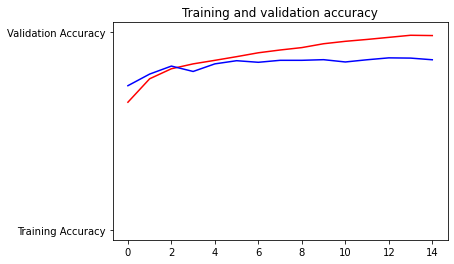

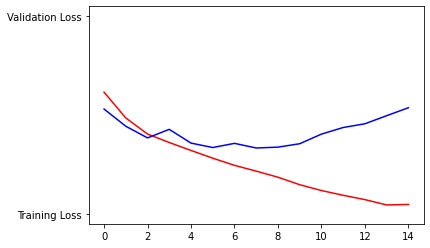

In [35]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [36]:
def download_history():
    
    import pickle
    from google.colab import files

    with open('history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    files.download('history.pkl')

download_history()

ModuleNotFoundError: No module named 'google.colab'